## Project: Retail

**Context:** 

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

**Data Description:**

> InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 

> StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 

> Description: Product (item) name. Nominal. 

> Quantity: The quantities of each product (item) per transaction. Numeric. 

> InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated. 

> UnitPrice: Unit price. Numeric, Product price per unit in sterling. 

> CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

> Country: Country name. Nominal, the name of the country where each customer resides.


**Probem Statement**

It is a business critical requirement to understand the value derived from a customer. RFM is a method used for analyzing customer value.
Perform customer segmentation using RFM analysis. The resulting segments can be ordered from most valuable (highest recency, frequency, and value) to least valuable (lowest recency, frequency, and value). Identifying the most valuable RFM segments can capitalize on chance relationships in the data used for this analysis.


In [1]:
# Import all the required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the data set
retail=pd.read_excel('Online Retail.xlsx')

In [3]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Approach

1.	Perform a preliminary data inspection and Data cleaning

>a.	Check for missing data and formulate apt strategy to treat them.

>b.	Are there any duplicate data records? Remove them if present.

>c.	Perform Descriptive analytics on the given data.


#### Treating Missing Data

In [4]:
# checking for missing data
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# Finding the perecentage of missing data in Customer ID and Description
retail.isna().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

Customer ID has around 25% of missing data hence dropping the rows with missing customer ID

In [6]:
retail.dropna(subset=['CustomerID'],axis=0,inplace=True)

In [7]:
# Checking for missing data again
retail.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#### Treating Duplicates

In [8]:
# Checking for any duplicate data
retail[retail.duplicated()].shape

(5225, 8)

In [9]:
# dropping duplicate data
retail.drop_duplicates(inplace=True)

In [10]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.6+ MB


#### Descriptive Analysis

In [11]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


2.	Cohort Analysis: A cohort is a group of subjects who share a defining characteristic. We can observe how a cohort behaves across time and compare it to other cohorts. 

a.	Create month cohorts and analyse active  customers for each cohort.

b.	Also Analyse the retention rate of customers. Comment.

In [12]:
# Define a function to parse the invoice date to one  day of the month
def get_month(x): return dt.datetime(x.year, x.month, 1)

In [13]:
# parsing the Invoice date to one day of the month in the dataset
retail['Transaction_Month']=retail['InvoiceDate'].apply(get_month)

In [14]:
# Calculating the Cohort Month
retail['Cohort_month']=retail.groupby('CustomerID')['Transaction_Month'].transform('min')

In [15]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Month,Cohort_month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [16]:
# Function to extract Month and year from the Transcation Month and Cohort Month
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [17]:
# Extract Month and year from the Transcation Month and Cohort Month
transcation_year, transaction_month, _ = get_date_int(retail, 'Transaction_Month')
cohort_year, cohort_month, _ = get_date_int(retail, 'Cohort_month')

In [18]:
# Calculate the differences in Months and Years between Cohort Month and Transcation Month
years_diff = transcation_year - cohort_year
months_diff = transaction_month - cohort_month
# Calculating the Cohort index by calculating the number of months from the cohort Month to Transaction Month, +1 is added to include the first month
retail['CohortIndex'] = years_diff * 12 + months_diff  + 1
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Month,Cohort_month,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1


a. Create month cohorts and analyse active customers for each cohort.

In [19]:
# Counting the daily active user from each chort
Cohort_activeuser=retail.groupby(['Cohort_month', 'CohortIndex'])['CustomerID'].nunique().reset_index()
# Create a pivot Table to display the cohort Month wise no. of active Customers across months
cohort_counts = Cohort_activeuser.pivot(index='Cohort_month',columns ='CohortIndex',values = 'CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
Cohort_month,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


b.  Also Analyse the retention rate of customers. Comment.

In [20]:
# Calculating the retention rate of Customers for each Cohort
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.index = retention.index.strftime('%Y-%m')
retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
Cohort_month,,,,,,,,,,,,,
2010-12,100.0,38.2,33.4,38.7,36.0,39.7,38.0,35.4,35.4,39.5,37.3,50.0,27.4
2011-01,100.0,24.0,28.3,24.2,32.8,29.9,26.1,25.7,31.1,34.7,36.8,15.0,NaN
2011-02,100.0,24.7,19.2,27.9,26.8,24.7,25.5,28.2,25.8,31.3,9.2,NaN,NaN
2011-03,100.0,19.1,25.5,21.8,23.2,17.7,26.4,23.9,28.9,8.9,NaN,NaN,NaN
2011-04,100.0,22.7,22.1,21.1,20.7,23.7,23.1,26.1,8.4,NaN,NaN,NaN,NaN
2011-05,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
2011-06,100.0,20.9,18.7,27.2,24.7,33.6,10.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.0,20.9,20.4,23.0,27.2,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.0,25.1,25.1,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='CohortIndex', ylabel='Cohort_month'>

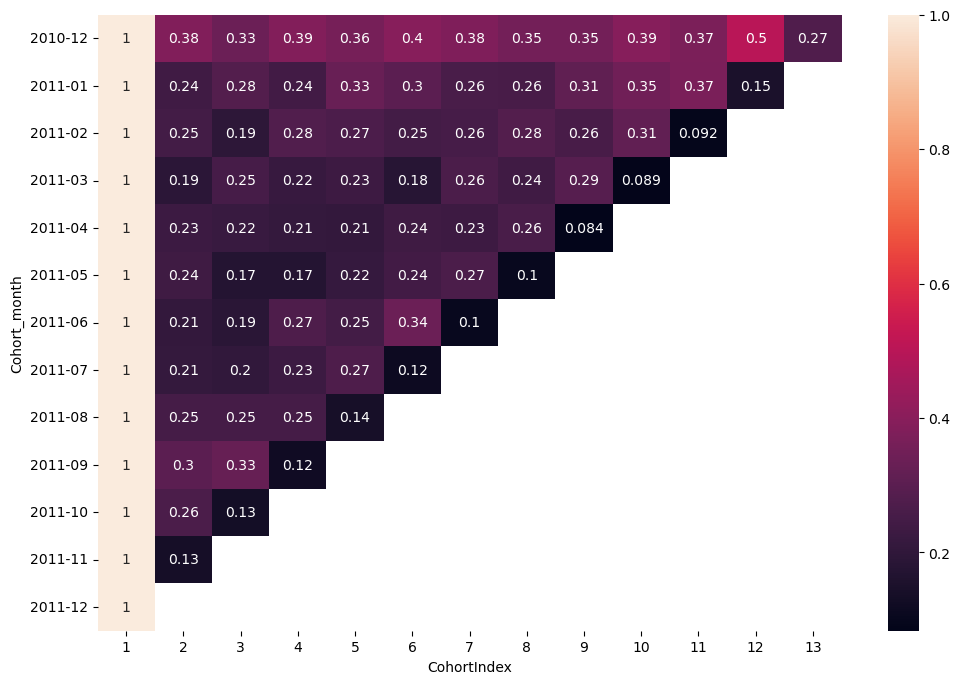

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(retention,annot=True)

Here, We have 13 cohorts for each month and 13 cohort indexes. If we see in 2010-12 cohort Month in 12th Cohort Index, we see the red shade with 50% which means that 50% of cohorts that signed in December 2010 were active 12 months later.

3.	Build a RFM model – Recency Frequency and Monetary based on their behaviour.
Recency is about when was the last order of a customer. It means the number of days since a customer made the last purchase. If it’s a case for a website or an app, this could be interpreted as the last visit day or the last login time.
Frequency is about the number of purchase in a given period. It could be 3 months, 6 months or 1 year. So we can understand this value as for how often or how many a customer used the product of a company. The bigger the value is, the more engaged the customers are. Could we say them as our VIP? Not necessary. Cause we also have to think about how much they actually paid for each purchase, which means monetary value.
Monetary is the total amount of money a customer spent in that given period. Therefore big spenders will be differentiated with other customers such as MVP or VIP.

a.	Calculate RFM metrics.
i.	Recency as the time in no. of days since last transaction
ii.	Frequency as  count of purchases done 
iii.	Monetary value  as total amount spend 

b.	Build RFM Segments.
i.	Give Recency Frequency and Monetary scores individually by dividing them in to quartiles.
Note: Rate "Recency" for customer who have been active more recently better than the less recent customer, because each company wants its customers to be recent 
Rate "Frequency" and "Monetary Value" higher label because we want Customer to spend more money and visit more often.
ii.	Combine three ratings to get a RFM segment (as strings)
iii.	Get the RFM score by adding up the three ratings.

c.	Analyse the RFM Segments by summarizing them and comment on the findings.


In [22]:
# Calculate the Total Amount
retail['Amount']=retail.Quantity*retail.UnitPrice

In [23]:
# Monetry- Customerwise amount Spent
monetry=retail.groupby('CustomerID')['Amount'].sum().reset_index()

In [24]:
# Frequency -No. of times the customer has visited the store
frequency=retail.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

In [25]:
monetry.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [26]:
frequency.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [27]:
# merging the Frequency and Montery dataframe
fm=pd.merge(frequency,monetry,on='CustomerID')

In [28]:
fm.head()

,CustomerID,InvoiceNo,Amount
0,12346.0,2,0.00
1,12347.0,7,4310.00
2,12348.0,4,1797.24
3,12349.0,1,1757.55
4,12350.0,1,334.40


In [29]:
# To calculate the Recency considering the last Invoice date as the last_date
last_date=retail['InvoiceDate'].max()
last_date

Timestamp('2011-12-09 12:50:00')

In [30]:
retail['diff']=last_date-retail['InvoiceDate']

In [31]:
retail['diff']=retail['diff'].dt.days

In [32]:
retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Month,Cohort_month,CohortIndex,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1,15.30,373
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,20.34,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1,22.00,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,20.34,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,20.34,373
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-01,2011-08-01,5,10.20,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01,2011-08-01,5,12.60,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01,5,16.60,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01,5,16.60,0


In [33]:
# Recency - Customer wise latest vist to the store
recency=retail.groupby('CustomerID').min()['diff'].reset_index()

In [34]:
recency.head()

,CustomerID,diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [35]:
# merging the recency table with Frequency and Monetry Dataframe
rfm=pd.merge(recency,fm,on='CustomerID')

In [36]:
rfm.columns=['CustomerID','Recency','Frequency','Monetry']

In [37]:
rfm.head()

,CustomerID,Recency,Frequency,Monetry
0,12346.0,325,2,0.00
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


b. Build RFM Segments. i. Give Recency Frequency and Monetary scores individually by dividing them in to quartiles. Note: Rate "Recency" for customer who have been active more recently better than the less recent customer, because each company wants its customers to be recent Rate "Frequency" and "Monetary Value" higher label because we want Customer to spend more money and visit more often. ii. Combine three ratings to get a RFM segment (as strings) iii. Get the RFM score by adding up the three ratings.

In [38]:
# Descriptive Statistics for recency
rfm.Recency.describe()

count    4372.000000
mean       91.047118
std       100.765435
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

In [39]:
# Descriptive Statistics for Frequency
rfm.Frequency.describe()

count    4372.000000
mean        5.075480
std         9.338754
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       248.000000
Name: Frequency, dtype: float64

In [40]:
# Descriptive Statistics for Monetry
rfm.Monetry.describe()

count      4372.000000
mean       1893.531433
std        8218.696204
min       -4287.630000
25%         291.795000
50%         644.070000
75%        1608.335000
max      279489.020000
Name: Monetry, dtype: float64

In [41]:
quantiles=rfm[['Recency','Frequency','Monetry']].quantile(q=[0.25,0.5,0.75])
quantiles=quantiles.to_dict()
quantiles

{'Recency': {0.25: 16.0, 0.5: 49.0, 0.75: 142.0},
 'Frequency': {0.25: 1.0, 0.5: 3.0, 0.75: 5.0},
 'Monetry': {0.25: 291.795, 0.5: 644.0699999999999, 0.75: 1608.335}}

In [42]:
# function to create RFM Segments
def Rscoring(x,p,d):
    if x<=d[p][0.25]:
        return 1
    elif x<=d[p][0.5]:
        return 2
    elif x<=d[p][0.75]:
        return 3
    else:
        return 4
    
def FnMscoring(x,p,d):
    if x<=d[p][0.25]:
        return 4
    elif x<=d[p][0.5]:
        return 3
    elif x<=d[p][0.75]:
        return 2
    else:
        return 1

In [43]:
# Calculate R F M quantile ratings
rfm['R']=rfm.Recency.apply(Rscoring,args=('Recency',quantiles))
rfm['F']=rfm.Frequency.apply(FnMscoring,args=('Frequency',quantiles))
rfm['M']=rfm.Monetry.apply(FnMscoring,args=('Monetry',quantiles))
rfm.head()

,CustomerID,Recency,Frequency,Monetry,R,F,M
0,12346.0,325,2,0.00,4,3,4
1,12347.0,1,7,4310.00,1,1,1
2,12348.0,74,4,1797.24,3,2,1
3,12349.0,18,1,1757.55,2,4,1
4,12350.0,309,1,334.40,4,4,3


In [44]:
# Combining 3 ratings to get RFM segment (as Strings)
rfm['RFM_segment']=rfm.R.map(str)+rfm.F.map(str)+rfm.M.map(str)

In [45]:
# adding up R F M ratings to obtain RFM score
rfm['RFM_Score']=rfm[['R','F','M']].sum(axis=1)

In [46]:
rfm.head(10)

,CustomerID,Recency,Frequency,Monetry,R,F,M,RFM_segment,RFM_Score
0,12346.0,325,2,0.00,4,3,4,434,11
1,12347.0,1,7,4310.00,1,1,1,111,3
2,12348.0,74,4,1797.24,3,2,1,321,6
3,12349.0,18,1,1757.55,2,4,1,241,7
4,12350.0,309,1,334.40,4,4,3,443,11
5,12352.0,35,11,1545.41,2,1,2,212,5
6,12353.0,203,1,89.00,4,4,4,444,12
7,12354.0,231,1,1079.40,4,4,2,442,10
8,12355.0,213,1,459.40,4,4,3,443,11
9,12356.0,22,3,2811.43,2,3,1,231,6


c. Analyse the RFM Segments by summarizing them and comment on the findings.

In [47]:
# Assigning Loyalty level to each customer based on RFM score in an ordinal scale of Platinum-Gold-Silver-Classic
Loyalty_level=['Platinum','Gold','Silver','Bronze']
Score_cuts=pd.qcut(rfm.RFM_Score,q=4,labels=Loyalty_level)
rfm['Customer_loyalty_level']=Score_cuts.values
rfm

,CustomerID,Recency,Frequency,Monetry,R,F,M,RFM_segment,RFM_Score,Customer_loyalty_level
0,12346.0,325,2,0.00,4,3,4,434,11,Bronze
1,12347.0,1,7,4310.00,1,1,1,111,3,Platinum
2,12348.0,74,4,1797.24,3,2,1,321,6,Gold
3,12349.0,18,1,1757.55,2,4,1,241,7,Gold
4,12350.0,309,1,334.40,4,4,3,443,11,Bronze
...,...,...,...,...,...,...,...,...,...,...
4367,18280.0,277,1,180.60,4,4,4,444,12,Bronze
4368,18281.0,180,1,80.82,4,4,4,444,12,Bronze
4369,18282.0,7,3,176.60,1,3,4,134,8,Gold
4370,18283.0,3,16,2045.53,1,1,1,111,3,Platinum


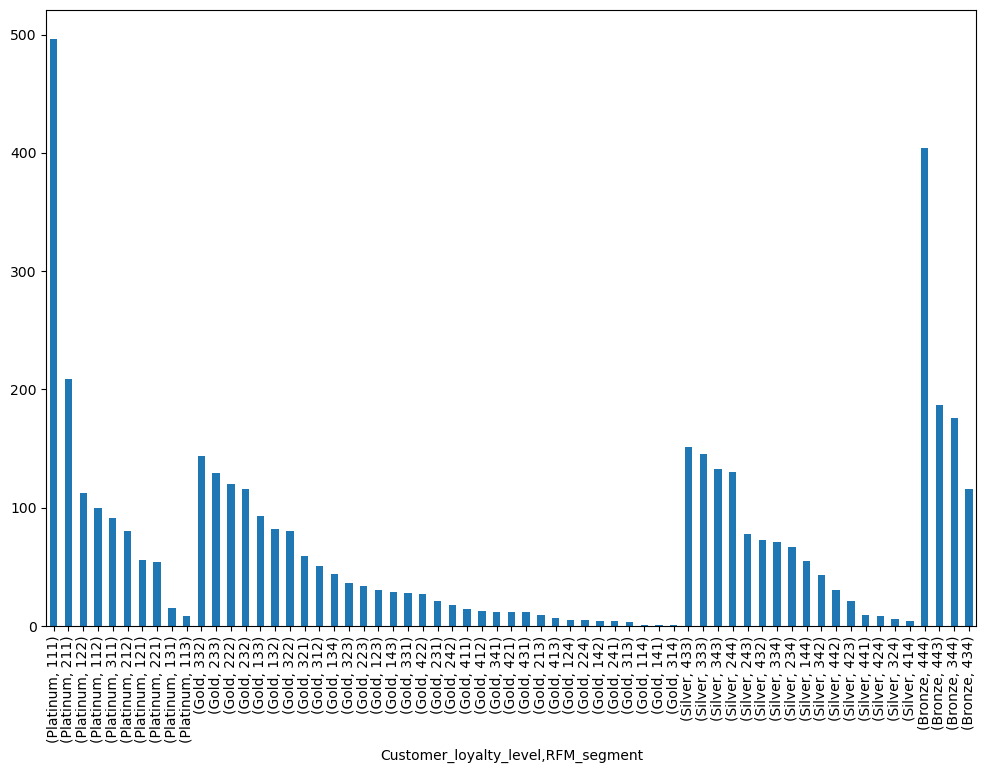

In [48]:
plt.figure(figsize=(12, 8))
rfm.groupby('Customer_loyalty_level')['RFM_segment'].value_counts().plot(kind='bar')
plt.xticks(rotation=90);

The Above graph shows, the customer counts based on RFM Segment and Loyalty level

In [49]:
rfm.Customer_loyalty_level.value_counts()

Gold        1244
Platinum    1221
Silver      1024
Bronze       883
Name: Customer_loyalty_level, dtype: int64

In [50]:
rfm.Customer_loyalty_level.value_counts(normalize=True)

Gold        0.284538
Platinum    0.279277
Silver      0.234218
Bronze      0.201967
Name: Customer_loyalty_level, dtype: float64

<AxesSubplot:xlabel='Customer_loyalty_level', ylabel='count'>

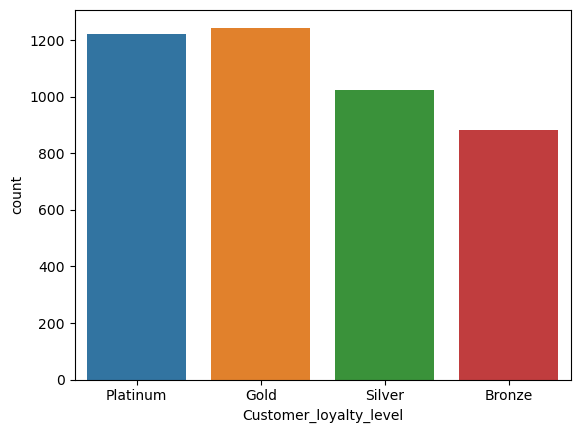

In [51]:
sns.countplot(rfm.Customer_loyalty_level)

The above Graph shows the Customer Grouping based on their Loyalty level based on recency, frequency and Monetry

>28% of Customers are having Platinum Level who are very good in terms of recency, frequency and Monetry

>28% of Customers are having Gold level who are fair in terms of recency, frequency and Monetry

>23.4%  of Customers are in Silver level who are not very recent, frequent and monetry

>20% of Customers are Bronze level who are not recent, frequent and monetry 

4.	Create clusters using k means clustering algorithm.
a.	Prepare the data for the algorithm.
i.	If the data is Un Symmetrically distributed, manage the skewness with appropriate transformation.
ii.	Standardize / scale the data.
b.	Decide the optimum number of clusters to be formed
c.	Analyse these clusters and comment on the results.


In [52]:
# Extracting the Columns CustomerID, Recency,Frequency and Monetry data in to seperate Dataframe since data need outlier Transformation
rfm_clustering=rfm[['CustomerID','Recency','Frequency','Monetry']]
rfm_clustering.shape

(4372, 4)

<AxesSubplot:xlabel='Recency'>

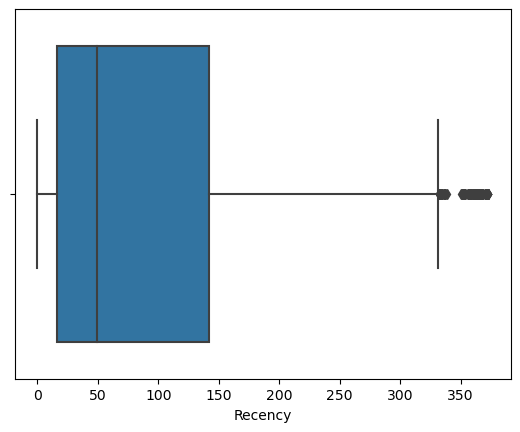

In [53]:
# Checking the data distribution using BoxPlot
sns.boxplot(rfm_clustering.Recency)

<AxesSubplot:xlabel='Frequency'>

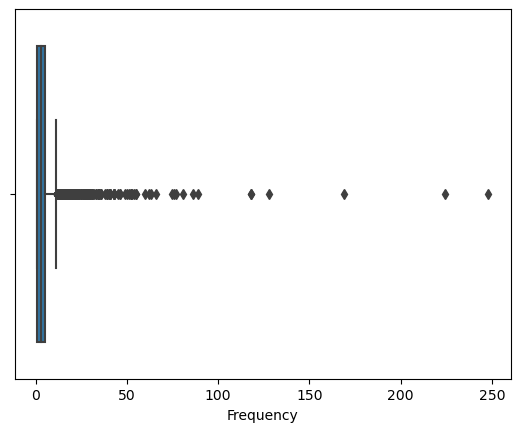

In [54]:
sns.boxplot(rfm_clustering.Frequency)

<AxesSubplot:xlabel='Monetry'>

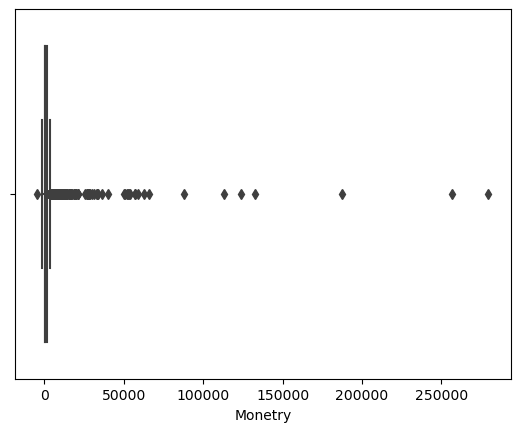

In [55]:
sns.boxplot(rfm_clustering.Monetry)

In [56]:
# function to treat Outliers
def treat_outlier(data, column,q1,q3, inplace=False):
    Q1=data[column].quantile(q1)
    Q3=data[column].quantile(q3)
    IQR=Q3-Q1
    
    outliers=data[((data[column]<Q1-1.5*(IQR))| (data[column]>Q3+1.5*(IQR)))]
    
    if inplace:
        return data[((data[column]>Q1-1.5*(IQR)) & (data[column]<Q3+1.5*(IQR)))]
    if not inplace:
        return outliers.shape[0]/data.shape[0]

#### Treating outliers for Monetry, Frequency and Recency

In [57]:
rfm_clustering=treat_outlier(rfm_clustering,'Monetry',0.15,0.85,inplace=True)

In [58]:
rfm_clustering=treat_outlier(rfm_clustering,'Frequency',0.2,0.8,inplace=True)

In [59]:
rfm_clustering=treat_outlier(rfm_clustering,'Recency',0.25,0.75,inplace=True)

In [60]:
rfm_clustering

,CustomerID,Recency,Frequency,Monetry
0,12346.0,325,2,0.00
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40
...,...,...,...,...
4366,18278.0,73,1,173.90
4367,18280.0,277,1,180.60
4368,18281.0,180,1,80.82
4369,18282.0,7,3,176.60


In [61]:
scaler=StandardScaler()

In [62]:
# Scaling the Data
rfm_scaled=scaler.fit_transform(rfm_clustering[['Monetry','Frequency','Recency']])

In [63]:
rfm_scaled.shape

(3910, 3)

#### K-Means Cluster

In [64]:
kmeans=KMeans(n_clusters=2)
kmeans.fit(rfm_scaled)

KMeans(n_clusters=2)

Elbow method to decide optimum no of clusters

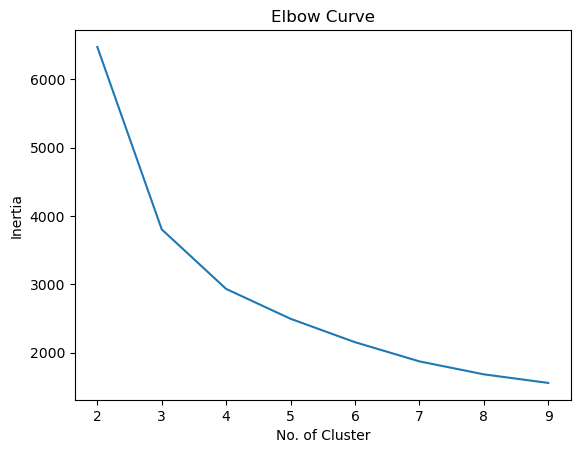

In [65]:
inertia=list()

for k in range (2,10):
    km=KMeans(n_clusters=k)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)
    
plt.plot(range(2,10),inertia)
plt.xlabel('No. of Cluster')
plt.ylabel('Inertia')
plt.title('Elbow Curve');

In [66]:
Cluster_Error=pd.DataFrame(range(2,10),columns=['No_Cluster'])
Cluster_Error['Error']=inertia
Cluster_Error

,No_Cluster,Error
0,2,6474.209326
1,3,3804.356155
2,4,2933.276741
3,5,2496.519080
4,6,2154.021855
5,7,1873.518086
6,8,1683.712773
7,9,1558.137007


In [67]:
km_optimum=KMeans(n_clusters=3)
km_optimum.fit(rfm_scaled)

KMeans(n_clusters=3)

In [68]:
rfm_clustering['km_labels']=km_optimum.labels_

In [69]:
rfm_clustering

,CustomerID,Recency,Frequency,Monetry,km_labels
0,12346.0,325,2,0.00,2
1,12347.0,1,7,4310.00,1
2,12348.0,74,4,1797.24,0
3,12349.0,18,1,1757.55,0
4,12350.0,309,1,334.40,2
...,...,...,...,...,...
4366,18278.0,73,1,173.90,0
4367,18280.0,277,1,180.60,2
4368,18281.0,180,1,80.82,2
4369,18282.0,7,3,176.60,0


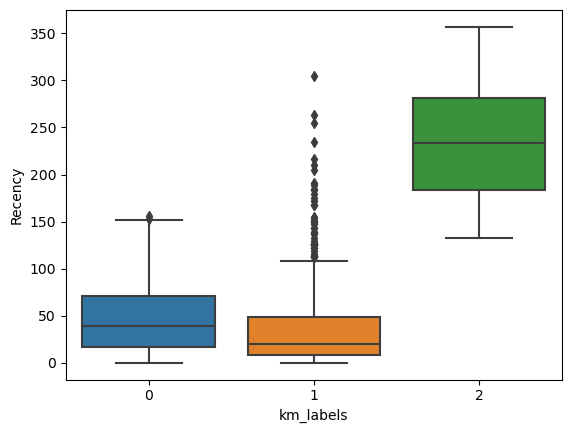

In [70]:
sns.boxplot(x=rfm_clustering.km_labels,y=rfm_clustering.Recency);

Above box Plot indicate recency distribution of customers based on Clustering, where cluster 2 customers are not recent when compared to cluster 0 and 1

<AxesSubplot:xlabel='km_labels', ylabel='Frequency'>

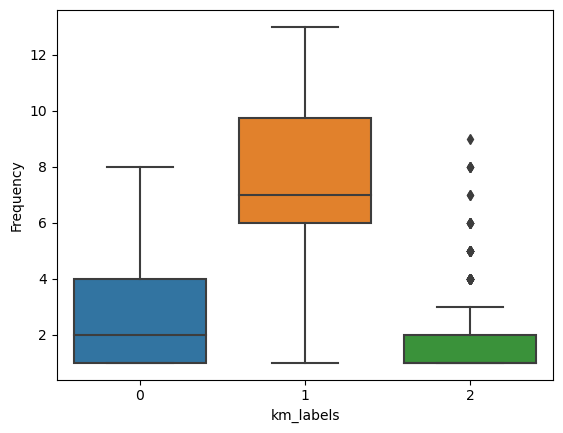

In [71]:
sns.boxplot(x=rfm_clustering.km_labels,y=rfm_clustering.Frequency)

Above box Plot indicate Frequency distribution of customers based on Clustering, where Cluster 2 customers are less frequent when compared to cluster 0 & 1

<AxesSubplot:xlabel='km_labels', ylabel='Monetry'>

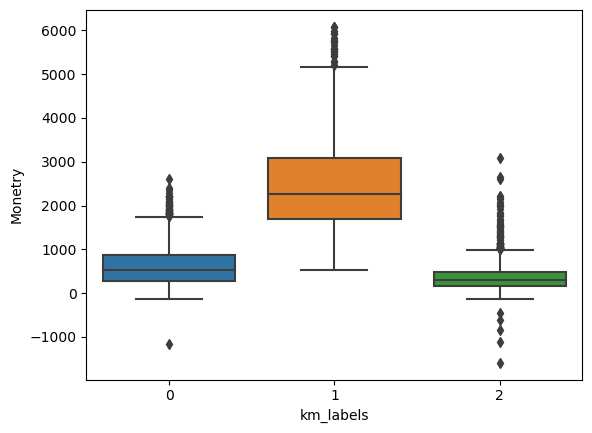

In [72]:
sns.boxplot(x=rfm_clustering.km_labels,y=rfm_clustering.Monetry)

Above box Plot indicate Monetry distribution of customers based on Clustering, cluster 2 customers spend is less when compared with cluster 0 and 1

In [73]:
# Transfering the retail and rfm dataframe to excel for preparing the report in Tableau
retail.to_excel('retail_treated.xlsx')
rfm.to_excel('rfm.xlsx')
Cluster_Error.to_excel('Cluster_Error.xlsx')
rfm_clustering.to_excel('rfm_clustering.xlsx')